# Data analysis notebook

Notebook contains two parts:
1. *Paper Figures Generator* prepares the figures that are present in the paper,
2. *Supplementary figures generator* prepares supplementary figures that are not present in the paper, but can be helpful for getting insight into the underlying data.

**Paper figures are saved in the Paper_Figures directory.**

**By default, after downloading the directory, you will be able to run the code for figures:**

**5, 6, 7, A13, 8, A.9, A.10, A.11 and A.12 in this order.**

**where the order of figures is dictated by the sequential logic used to generate them.***

**Without access to German intraday continuous market you will not be able to plot figures 1 and 2.**

**You can still generate the other figures - clicking on the next cell and Shift + Enter will run the next ipynb cell after the previous one failed**

In [93]:
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.ticker as mtick
import sqlite3
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

from Forecasting.forecasting_config import forecasting_config

Matplotlib latex config:

In [71]:
plt.rc("text", usetex=True)  # latex ticks
plt.rc("text.latex")
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
    }
)
plt.rcParams["axes.linewidth"] = 0.4
plt.rcParams["xtick.major.width"] = 0.4
plt.rcParams["xtick.minor.width"] = 0.2
plt.rcParams["ytick.major.width"] = 0.4
plt.rcParams["ytick.minor.width"] = 0.2
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"

Slide_show_width = 4.71512
Paper_width = 6.30045
Format = 1
if Format == 0:
    Image_width = Slide_show_width
if Format == 1:
    Image_width = Paper_width

EXTRA_SMALL = 4
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 9

plt.rc("font", size=EXTRA_SMALL)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("ytick", labelsize=EXTRA_SMALL)  # fontsize of the tick labels
plt.rc("legend", fontsize=EXTRA_SMALL)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

Global config for the notebook:

In [ ]:
raw_data_available = False  # if available, plot also Figures 1 and 2
run_the_additional_analysis = False  # some additional analysis is left below the code needed to regenerate the plots from the paper - by default it is not needed
all_forecasting_horizons = forecasting_config["forecasting_horizons"]
lead_times = forecasting_config["lead_times"]
significance = 0.05  # significance lvl to count the Diebold-Mariano test
path_to_mae_aggregations = os.path.join(
    "Forecasting", forecasting_config["mae_aggregation_results_dir"]
)

# *Paper Figures Generator*

## Fig 1

In [73]:
if raw_data_available:
    df = pd.read_csv(
        "Data/preprocessed_dataset.csv"
    )  # loading the minutely avg. continuous intraday prices

    con = sqlite3.connect(
        "Forecasting/data_ID.db"
    )  # load the preprocessed continuous intraday prices used in forecasting study

    sql_str = "SELECT * FROM with_dummies;"  # load only the data required for simu, so up to trade time
    daily_data = pd.read_sql(sql_str, con)
    daily_data["Time"] = pd.to_datetime(daily_data["Time"])

In [74]:
if raw_data_available:
    fig, axs = plt.subplots(ncols=2, figsize=(Image_width, 0.4 * Image_width))

    ax = axs[0]
    ttd_minutely = pd.date_range(
        datetime(year=2020, month=11, day=2, hour=16),
        datetime(year=2020, month=11, day=4, hour=0),
        freq="1min",
    )
    idxs = [int(7 * 4), int(10 * 4), int(15 * 4)]
    labels = ["7:00", "10:00", "15:00", "19:00"]
    for d_i, dat in enumerate(
        [
            "2020-11-03 07:00:00",
            "2020-11-03 10:00:00",
            "2020-11-03 15:00:00",
            "2020-11-03 19:00:00",
        ]
    ):
        current_data_avg = df[df["Datetime from"] == dat].groupby(
            "Time to delivery", as_index=False
        )
        price = []
        time_to_delivery = []
        for group in current_data_avg:
            price.append(
                np.sum(
                    group[1]["Price (EUR)"].to_numpy()
                    * group[1]["Volume (MW)"].to_numpy()
                )
                / np.sum(group[1]["Volume (MW)"])
            )
            time_to_delivery.append(
                pd.to_datetime(dat)
                - timedelta(minutes=group[1]["Time to delivery"].to_numpy()[0])
            )
        ax.plot(
            time_to_delivery,
            price,
            marker=".",
            ls="--",
            markersize=0.5,
            alpha=0.5,
            label=labels[d_i],
            lw=0.3,
        )

    ax.set_ylabel("[EUR/MWh]")
    hours = mdates.HourLocator(interval=1)
    ax.xaxis.set_minor_locator(hours)
    ax.set_title("Minutely prices avgs.")
    plt.grid(which="both", axis="x")

    ax = axs[1]
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["28"],
        label=labels[0],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["40"],
        label=labels[1],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["60"],
        label=labels[2],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["76"],
        label=labels[3],
        lw=0.3,
    )
    ax.set_title("Preprocessed prices")
    ax.xaxis.set_minor_locator(hours)
    plt.grid(which="both", axis="x")
    plt.gcf().autofmt_xdate()
    fig.legend(
        loc="outside lower center",
        ncol=8,
        frameon=False,
        borderaxespad=0,
        bbox_to_anchor=(0.5, 0.02),
    )
    fig.autofmt_xdate()
    plt.savefig("Paper_Figures/example_of_preprocessing.pdf", bbox_inches="tight")
else:
    print(
        "Figure 1 is not possible to generate based on the publicly available dataset. You can find it in Paper Figures."
    )

Figure 1 is not possible to generate based on the publicly available dataset. You can find it in Paper Figures.


## Fig 2

In [75]:
if raw_data_available:
    fig, axs = plt.subplots(ncols=2, figsize=(Image_width, 0.4 * Image_width))

    ax = axs[0]
    ttd_minutely = pd.date_range(
        datetime(year=2020, month=11, day=2, hour=16),
        datetime(year=2020, month=11, day=4, hour=0),
        freq="1min",
    )
    idxs = [int(7 * 4), int(10 * 4), int(15 * 4)]
    labels = ["7:00", "10:00", "15:00", "19:00"]
    for d_i, dat in enumerate(
        [
            "2020-11-03 07:00:00",
            "2020-11-03 10:00:00",
            "2020-11-03 15:00:00",
            "2020-11-03 19:00:00",
        ]
    ):
        current_data_avg = df[df["Datetime from"] == dat].groupby(
            "Time to delivery", as_index=False
        )
        price = []
        time_to_delivery = []
        for group in current_data_avg:
            price.append(np.sum(group[1]["Volume (MW)"]))
            time_to_delivery.append(
                pd.to_datetime(dat)
                - timedelta(minutes=group[1]["Time to delivery"].to_numpy()[0])
            )
        ax.plot(
            time_to_delivery,
            price,
            marker=".",
            ls="--",
            markersize=0.5,
            alpha=0.5,
            label=labels[d_i],
            lw=0.3,
        )

    ax.set_ylabel("[MW]")
    hours = mdates.HourLocator(interval=1)
    ax.xaxis.set_minor_locator(hours)
    ax.set_title("Minutely volume sum")
    plt.grid(which="both", axis="x")

    ax = axs[1]
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["124"],
        label=labels[0],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["136"],
        label=labels[1],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["156"],
        label=labels[2],
        lw=0.3,
    )
    ax.plot(
        daily_data[daily_data["Day"] == 733]["Time"],
        daily_data[daily_data["Day"] == 733]["172"],
        label=labels[3],
        lw=0.3,
    )
    ax.set_title("Preprocessed volumes")
    ax.xaxis.set_minor_locator(hours)
    plt.grid(which="both", axis="x")
    plt.gcf().autofmt_xdate()
    fig.legend(
        loc="outside lower center",
        ncol=8,
        frameon=False,
        borderaxespad=0,
        bbox_to_anchor=(0.5, 0.02),
    )
    plt.savefig(
        "Paper_Figures/volume_example_of_preprocessing.pdf", bbox_inches="tight"
    )
else:
    print(
        "Figure 2 is not possible to generate based on the publicly available dataset. You can find it in Paper Figures."
    )

Figure 2 is not possible to generate based on the publicly available dataset. You can find it in Paper Figures.


## !NOTE! that Figures 3 and 4 are coded in LaTeX and thus are not included here

## Fig 5 and Table 2 generation

Iterating through the MAE aggregations pickles for every delivery and loading them to analyze the results.

The table saved in the .csv file contains the aggregated results for all of the models.

**Table consistent with one in the paper is also displayed below the cell for clarity.**

In [ ]:
# load the MAE and QAPE results for the 60min lead time
deliveries = np.arange(96)

quantile_mae_results = {}

for measure_type in ["avg", "quantile_0.5", "quantile_0.25", "quantile_0.75"]:
    quantile_mae_results[measure_type] = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    os.path.join(
                        path_to_mae_aggregations,
                        f"{measure_type}_mae_results_60_{delivery}.pickle",
                    ),
                    "rb",
                )
            )
            quantile_mae_results[measure_type][delivery] = mae_results_delivery
        except Exception as err:
            print(err)
            print(f"delivery {delivery} not found")

# !NOTE! the additional (vanilla SVR) forecasts were performed and analyzed in the process of paper revision: due to their limited scope we store their results in a separate directory
quantile_mae_results_complete_svr = {}

for measure_type in ["avg", "quantile_0.5", "quantile_0.25", "quantile_0.75"]:
    quantile_mae_results_complete_svr[measure_type] = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    f"Forecasting/RESULTS/VANILLA_SVR_MAE/{measure_type}_mae_results_60_{delivery}.pickle",
                    "rb",
                )
            )
            quantile_mae_results_complete_svr[measure_type][delivery] = (
                mae_results_delivery
            )
        except Exception as err:
            print(err)
            print(f"delivery {delivery} not found")

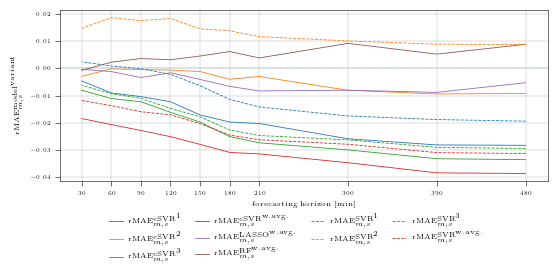

In [77]:
time_to_delivery = 0
fig, ax = plt.subplots(figsize=(Paper_width, 0.4 * Paper_width))

colors_list = list(mcolors.BASE_COLORS.keys())

# map of curve colors to use on the plot for each prediction
colors_map = {
    "prediction_1": "#1f77b4",
    "prediction_2": "#ff7f0e",
    "prediction_7": "#2ca02c",
    "prediction_32": "#d62728",
    "prediction_32lasso": "#9467bd",
    "prediction_32random_forest": "#8c564b",
    "prediction_plain_laplace_L2_1": "#1f77b4",
    "prediction_plain_laplace_L2_2": "#ff7f0e",
    "prediction_plain_laplace_L2_3": "#2ca02c",
}

# maps of latex names for each prediction key
latex_kernel_names_map = {
    "naive": """na\"{\i}ve""",
    "prediction_1": "$\mathrm{rMAE}^{\mathrm{cSVR}^1}_{m,s}$",
    "prediction_2": "$\mathrm{rMAE}^{\mathrm{cSVR}^2}_{m,s}$",
    "prediction_7": "$\mathrm{rMAE}^{\mathrm{cSVR}^3}_{m,s}$",
    "prediction_32": "$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32lasso": "$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32random_forest": "$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",
}
vanila_svr_latex_kernel_names_map = {
    "prediction_plain_laplace_L2_1": "$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^1}_{m,s}$",
    "prediction_plain_laplace_L2_2": "$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^2}_{m,s}$",
    "prediction_plain_laplace_L2_3": "$\mathrm{\mathrm{rMAE}}^{\mathrm{SVR}^3}_{m,s}$",
    "prediction_32": "$\mathrm{rMAE}^{\mathrm{SVR}^{\mathrm{w. avg.}}}_{m,s}$",
}

# models that performed worse so we do not add them to the MAE plot - only to the MAE table
worse_performing_models = {
    "predictionlasso": "$\hat{P}_{LASSO}^{1}$",
    "prediction_closelasso": "$\hat{P}_{LASSO}^{2}$",
    "prediction_exoglasso": "$\hat{P}_{LASSO}^{3}$",
    "predictionrandom_forest": "$\hat{P}_{RF}^{1}$",
    "prediction_closerandom_forest": "$\hat{P}_{RF}^{2}$",
    "prediction_exograndom_forest": "$\hat{P}_{RF}^{3}$",
}

avgs_table = pd.DataFrame()

for var_set in [11]:  # variables sets numbers to analyse
    # add the LASSO RF and cSVR results to the plot
    for forecast_technique in list(latex_kernel_names_map.keys()) + list(
        worse_performing_models.keys()
    ):
        results = {}
        counter_dict = {}

        for delivery in quantile_mae_results["avg"].keys():
            for horizon in all_forecasting_horizons:
                if horizon not in results.keys():
                    results[horizon] = 0
                    counter_dict[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in quantile_mae_results["avg"][delivery][horizon].keys():
                    if len(quantile_mae_results["avg"][delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                    elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - 60:
                        print(
                            f"Delivery {delivery} results are not available for horizon {horizon}"
                        )

                if len(trade_times) > 0:
                    trade_time = trade_times[time_to_delivery]

                    if (
                        len(quantile_mae_results["avg"][delivery][horizon][trade_time])
                        > 0
                        and "naive"
                        in quantile_mae_results["avg"][delivery][horizon][
                            trade_time
                        ].keys()
                    ):
                        results[horizon] += quantile_mae_results["avg"][delivery][
                            horizon
                        ][trade_time][forecast_technique]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in all_forecasting_horizons:
            if horizon == 30 and counter_dict[horizon] != 96:
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique == "naive":
            naive_results = results_plot
        else:
            if forecast_technique in list(latex_kernel_names_map.keys()):
                ax.plot(
                    all_forecasting_horizons,
                    (np.array(results_plot) - np.array(naive_results))
                    / np.array(naive_results),
                    label=latex_kernel_names_map[forecast_technique],
                    lw=0.6,
                    color=colors_map[forecast_technique],
                )
                avgs_table[latex_kernel_names_map[forecast_technique]] = [
                    np.mean(
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results)
                    )
                ]
            else:
                avgs_table[worse_performing_models[forecast_technique]] = [
                    np.mean(
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results)
                    )
                ]

        if forecast_technique == "prediction_32lasso":
            lasso_avg_mae = results_plot

    # add the vanilla SVR results
    for forecast_technique in list(vanila_svr_latex_kernel_names_map.keys()):
        results = {}
        counter_dict = {}
        for delivery in quantile_mae_results_complete_svr["avg"].keys():
            for horizon in all_forecasting_horizons:
                if horizon not in results.keys():
                    results[horizon] = 0
                    counter_dict[horizon] = 0
                # choose the trade time
                trade_times = []
                if horizon not in list(
                    quantile_mae_results_complete_svr["avg"][delivery].keys()
                ):
                    continue
                for trad in quantile_mae_results_complete_svr["avg"][delivery][
                    horizon
                ].keys():
                    if (
                        len(
                            quantile_mae_results_complete_svr["avg"][delivery][horizon][
                                trad
                            ]
                        )
                        > 0
                    ):
                        trade_times.append(trad)
                    elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - 60:
                        print(
                            f"Delivery {delivery} results are not available for horizon {horizon}"
                        )
                trade_time = trade_times[time_to_delivery]
                if (
                    len(
                        quantile_mae_results_complete_svr["avg"][delivery][horizon][
                            trade_time
                        ]
                    )
                    > 0
                    and "naive"
                    in quantile_mae_results_complete_svr["avg"][delivery][horizon][
                        trade_time
                    ].keys()
                ):
                    results[horizon] += quantile_mae_results_complete_svr["avg"][
                        delivery
                    ][horizon][trade_time][forecast_technique]
                    counter_dict[horizon] += 1

        results_plot = []
        for horizon in all_forecasting_horizons:
            if horizon == 30 and counter_dict[horizon] != 96:
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        ax.plot(
            all_forecasting_horizons,
            (np.array(results_plot) - np.array(naive_results))
            / np.array(naive_results),
            label=vanila_svr_latex_kernel_names_map[forecast_technique],
            lw=0.6,
            color=colors_map[forecast_technique],
            ls="--",
        )
        avgs_table[vanila_svr_latex_kernel_names_map[forecast_technique]] = [
            np.mean(
                (np.array(results_plot) - np.array(naive_results))
                / np.array(naive_results)
            )
        ]

        if forecast_technique == "prediction_32lasso":
            lasso_avg_mae = results_plot

ax.axhline(0, ls="--", lw=0.2)
ax.set_xlabel("forecasting horizon [min]")
ax.set_ylabel("$\mathrm{rMAE}^{\mathrm{model}^\mathrm{variant}}_{m,s}$")
fig.legend(
    loc="outside lower center",
    ncol=4,
    frameon=False,
    fontsize=5,
    bbox_to_anchor=(0.5, -0.15),
)

ax.set_xticks(all_forecasting_horizons)
ax.grid(visible=True, linewidth=0.3)

fig.autofmt_xdate(rotation=0, ha="center")
plt.savefig("Paper_Figures/relative_MAE_all_models.pdf", bbox_inches="tight")

### Table 2:

In [78]:
paper_table_2 = avgs_table[
    [
        "$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
        "$\mathrm{rMAE}^{\mathrm{SVR}^{\mathrm{w. avg.}}}_{m,s}$",
        "$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",
        "$\hat{P}_{LASSO}^{1}$",
        "$\hat{P}_{LASSO}^{2}$",
        "$\hat{P}_{LASSO}^{3}$",
        "$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",
        "$\hat{P}_{RF}^{1}$",
        "$\hat{P}_{RF}^{2}$",
        "$\hat{P}_{RF}^{3}$",
    ]
]
paper_table_2.to_csv("Paper_Tables/Table_2.csv")
paper_table_2

,"$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$","$\mathrm{rMAE}^{\mathrm{SVR}^{\mathrm{w. avg.}}}_{m,s}$","$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",$\hat{P}_{LASSO}^{1}$,$\hat{P}_{LASSO}^{2}$,$\hat{P}_{LASSO}^{3}$,"$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",$\hat{P}_{RF}^{1}$,$\hat{P}_{RF}^{2}$,$\hat{P}_{RF}^{3}$
0,-0.028957,-0.022021,-0.004773,0.065175,0.021344,0.003351,0.004618,0.040961,0.049845,0.046169


## Fig 6

In [ ]:
mae_results = {}
for delivery in deliveries:
    try:
        mae_results_delivery = pickle.load(
            open(
                os.path.join(
                    path_to_mae_aggregations, f"avg_mae_results_60_{delivery}.pickle"
                ),
                "rb",
            )
        )
        mae_results[delivery] = mae_results_delivery
    except Exception as err:
        print(f"Delivery {delivery} not found. Exception: {err}")

# prepare the relative MAE matrix
results_matrix = pd.DataFrame()
counter_dict = {}
col_chosen = "prediction_32"

for d, delivery in enumerate(mae_results.keys()):
    for h, horizon in enumerate(all_forecasting_horizons):
        if horizon not in counter_dict.keys():
            counter_dict[horizon] = 0
        # choose the trade time
        trade_times = []
        for trad in mae_results[delivery][horizon].keys():
            if len(mae_results[delivery][horizon][trad]) > 0:
                trade_times.append(trad)
            elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - 60:
                print(
                    f"Delivery {delivery} results are not available for horizon {horizon}"
                )
        if len(trade_times) > 0:
            trade_time = trade_times[0]
            if (
                len(mae_results[delivery][horizon][trade_time]) > 0
                and "naive" in mae_results[delivery][horizon][trade_time].keys()
                and mae_results[delivery][horizon][trade_time]["naive"]
            ):
                results_matrix.loc[horizon, delivery * 0.25] = (
                    (  # add the relative MAE to the matrix used later for the colormap plot
                        mae_results[delivery][horizon][trade_time][col_chosen]
                        - mae_results[delivery][horizon][trade_time]["naive"]
                    )
                    / mae_results[delivery][horizon][trade_time]["naive"]
                )
                counter_dict[horizon] += 1
if counter_dict[30] != 96:  # sanity check for the deliveries no.
    print(
        f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
    )
results_matrix = results_matrix.sort_index()

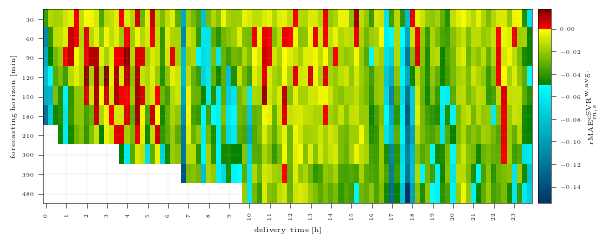

In [80]:
results_matrix = results_matrix.sort_index()

# prepare the custom colormap from red green and blue parts
colormap_partition = 1000  # how fine should the colormap be
green_part = int(
    0.05
    / (-np.nanmin(results_matrix.to_numpy()) + np.nanmax(results_matrix.to_numpy()))
    * colormap_partition
)
red_part = int(
    np.nanmax(results_matrix.to_numpy())
    / (-np.nanmin(results_matrix.to_numpy()) + np.nanmax(results_matrix.to_numpy()))
    * colormap_partition
)
blue_part = int(colormap_partition - green_part - red_part)

red = np.concatenate(
    [
        np.zeros(blue_part),
        np.linspace(0, 1, green_part),
        np.linspace(1, 0.5, red_part + 1)[1:],
    ]
)
green = np.concatenate(
    [
        np.linspace(0.2, 1, blue_part),
        np.linspace(0.5, 1, green_part),
        np.zeros(red_part),
    ]
)
blue = np.concatenate(
    [np.linspace(1, 0.4, blue_part)[::-1], np.zeros(green_part), np.zeros(red_part)]
)
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

# plot the colormap
fig, ax = plt.subplots(figsize=(Image_width, 0.4 * Image_width))
im = ax.imshow(
    results_matrix.astype(float).values,
    cmap=rgb_color_map,
    vmin=np.nanmin(results_matrix.to_numpy()),
    vmax=np.nanmax(results_matrix.to_numpy()),
    aspect="auto",
)
ax.set_xticks(
    range(len(results_matrix.columns)),
    [int(i) for i in results_matrix.columns],
    rotation=90.0,
)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery time [h]")
ax.set_ylabel("forecasting horizon [min]")
ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
ax.grid(True, linewidth=0.1)
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(
    im,
    cax=cbar_ax,
    pad=0.5,
    shrink=0.4,
    label="$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
)

plt.savefig(
    "Paper_Figures/3D_relative_mae_traded_60min_before_delivery.pdf",
    bbox_inches="tight",
)

## Fig 7

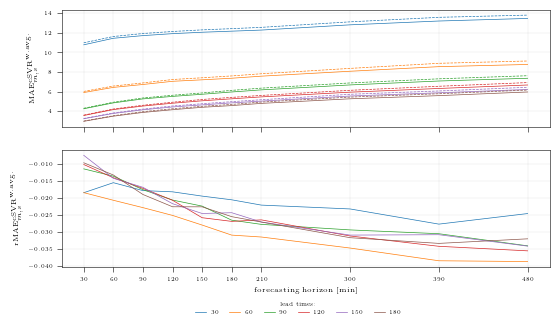

In [ ]:
plot_matrix = []

deliveries = np.arange(96)

for trade_vs_delivery_delta in lead_times:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    os.path.join(
                        path_to_mae_aggregations,
                        f"avg_mae_results_{trade_vs_delivery_delta}_{delivery}.pickle",
                        "rb",
                    )
                )
            )
            mae_results[delivery] = mae_results_delivery
        except Exception as err:
            print(
                f"delivery {delivery}, delivery - trade {trade_vs_delivery_delta} not found. Exception: {err}"
            )

    var_set = 11
    for forecast_technique in ["naive", "prediction_32"]:
        results = {}
        counter_dict = {}
        for delivery in mae_results.keys():
            for horizon in all_forecasting_horizons[::-1]:
                if horizon not in results.keys():
                    results[horizon] = 0
                    counter_dict[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in mae_results[delivery][horizon].keys():
                    if len(mae_results[delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                    elif (
                        2 * (20 + horizon) + 20
                    ) < delivery * 15 + 8 * 60 - trade_vs_delivery_delta:
                        print(
                            f"Delivery {delivery} results are not available for horizon {horizon}"
                        )
                if len(trade_times) > 0:
                    trade_time = trade_times[0]
                    if (
                        len(mae_results[delivery][horizon][trade_time]) > 0
                        and "naive" in mae_results[delivery][horizon][trade_time].keys()
                    ):
                        results[horizon] += mae_results[delivery][horizon][trade_time][
                            forecast_technique
                        ]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in all_forecasting_horizons[::-1]:
            if (
                horizon == 30 and counter_dict[horizon] != 96
            ):  # sanity check for the deliveries no.
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if horizon not in counter_dict.keys():
                results_plot.append(np.nan)
            elif counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            plot_matrix.append(
                (np.array(results_plot) - np.array(naive_results))
                / np.array(naive_results)
            )
        else:
            naive_results = results_plot

plot_matrix_naive = []
plot_matrix_model = []

deliveries = np.arange(96)

for trade_vs_delivery_delta in lead_times:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    os.path.join(
                        path_to_mae_aggregations,
                        f"avg_mae_results_{trade_vs_delivery_delta}_{delivery}.pickle",
                    ),
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except Exception as err:
            print(
                f"Delivery {delivery} and lead time {trade_vs_delivery_delta} combination not found. Exception: {err}"
            )

    var_set = 11
    for forecast_technique in ["naive", "prediction_32"]:
        results = {}
        counter_dict = {}
        for delivery in mae_results.keys():
            for horizon in all_forecasting_horizons[::-1]:
                if horizon not in results.keys():
                    results[horizon] = 0
                    counter_dict[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in mae_results[delivery][horizon].keys():
                    if len(mae_results[delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                    elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - 60:
                        print(
                            f"Delivery {delivery} results are not available for horizon {horizon}"
                        )
                if len(trade_times) > 0:
                    trade_time = trade_times[0]
                    if (
                        len(mae_results[delivery][horizon][trade_time]) > 0
                        and "naive" in mae_results[delivery][horizon][trade_time].keys()
                    ):
                        results[horizon] += mae_results[delivery][horizon][trade_time][
                            forecast_technique
                        ]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in all_forecasting_horizons[::-1]:
            if (
                horizon == 30 and counter_dict[horizon] != 96
            ):  # sanity check for the deliveries no.
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            plot_matrix_model.append(np.array(results_plot))
        else:
            plot_matrix_naive.append(np.array(results_plot))

fig, axs = plt.subplots(nrows=2, figsize=(Paper_width, 0.6 * Paper_width))

labels = lead_times
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

ax = axs[0]
for horizon in range(np.shape(plot_matrix_model)[0]):
    ax.plot(
        all_forecasting_horizons[::-1],
        plot_matrix_model[horizon],
        lw=0.5,
        color=colors[horizon],
    )
    ax.plot(
        all_forecasting_horizons[::-1],
        plot_matrix_naive[horizon],
        "--",
        lw=0.5,
        color=colors[horizon],
    )

ax.set_xlabel("forecasting horizon [min]")
ax.set_ylabel("$\mathrm{MAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$")

ax.set_xticks(all_forecasting_horizons[::-1])
ax.grid(visible=True, linewidth=0.1)

ax = axs[1]
for horizon in range(np.shape(plot_matrix)[0]):
    ax.plot(
        all_forecasting_horizons[::-1],
        plot_matrix[horizon],
        lw=0.5,
        label=labels[horizon],
        color=colors[horizon],
    )

ax.set_xlabel("forecasting horizon [min]")
ax.set_ylabel(" $\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$")
fig.legend(
    loc="outside lower center",
    ncol=6,
    frameon=False,
    bbox_to_anchor=(0.5, 0.06),
    title="lead times:",
)

ax.set_xticks(all_forecasting_horizons[::-1])
ax.grid(visible=True, linewidth=0.1)

fig.autofmt_xdate(rotation=0, ha="center")
plt.savefig(
    "Paper_Figures/naive_and_best_model_MAE_and_relative_MAE.pdf",
    bbox_inches="tight",
)

## Fig A13

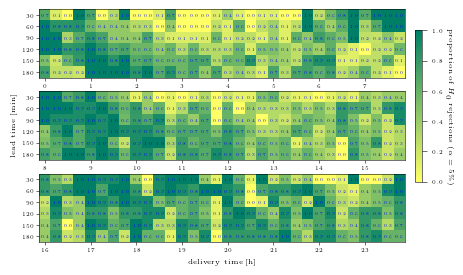

In [ ]:
col_chosen = "prediction_32_DM_wrt_naive_pval"

aggregated_DM_results = []

for trade_horizon in lead_times:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    os.path.join(
                        path_to_mae_aggregations,
                        f"avg_mae_results_{trade_horizon}_{delivery}.pickle",
                    ),
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except Exception as err:
            print(
                f"Delivery {delivery}, delivery - trade {trade_vs_delivery_delta} not found. Exception: {err}"
            )
    results_matrix = pd.DataFrame()
    mae_results_matrix = pd.DataFrame()
    counter_dict = {}
    for d, delivery in enumerate(mae_results.keys()):
        for h, horizon in enumerate(all_forecasting_horizons):
            if horizon not in counter_dict.keys():
                counter_dict[horizon] = 0
            # choose the trade time
            trade_times = []
            for trad in mae_results[delivery][horizon].keys():
                if len(mae_results[delivery][horizon][trad]) > 0:
                    trade_times.append(trad)
                elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - trade_horizon:
                    print(
                        f"Delivery {delivery} results are not available for horizon {horizon}"
                    )
            if len(trade_times) > 0:
                trade_time = trade_times[0]
                if len(mae_results[delivery][horizon][trade_time]) > 0:
                    results_matrix.loc[horizon, delivery * 0.25] = mae_results[
                        delivery
                    ][horizon][trade_time][col_chosen]
                    mae_results_matrix.loc[horizon, delivery * 0.25] = (
                        mae_results[delivery][horizon][trade_time]["prediction_32"]
                        - mae_results[delivery][horizon][trade_time]["naive"]
                    ) / mae_results[delivery][horizon][trade_time]["naive"]
                    counter_dict[horizon] += 1
    results_matrix = results_matrix.sort_index()
    mae_results_matrix = mae_results_matrix.sort_index()
    aggregated_DM_results.append(
        np.nansum(significance >= results_matrix.to_numpy(), axis=0)
        / np.sum(~np.isnan(results_matrix.to_numpy()), axis=0)
    )

# draw in three subplots
fig, axs = plt.subplots(nrows=3, figsize=(0.8 * Image_width, 0.8 * 0.6 * Image_width))
fig.subplots_adjust(hspace=0.2)
for i in range(3):
    dm_results_df = pd.DataFrame(
        columns=list(results_matrix.columns)[i * 32 : (i + 1) * 32],
        index=lead_times,
        data=np.vstack(aggregated_DM_results)[:, i * 32 : (i + 1) * 32],
    )
    ax = axs[i]
    im = ax.imshow(
        dm_results_df.astype(float).values,
        cmap="summer_r",
        vmin=np.nanmin(dm_results_df.to_numpy()),
        vmax=np.nanmax(dm_results_df.to_numpy()),
        aspect="auto",
    )
    ax.set_xticks(
        range(len(dm_results_df.columns)), [int(i) for i in dm_results_df.columns]
    )
    ax.set_yticks(range(len(dm_results_df.index)), dm_results_df.index)
    ax.tick_params(axis="both", length=2, pad=2)
    if i == 2:
        ax.set_xlabel("delivery time [h]")
    if i == 1:
        ax.set_ylabel("lead time [min]")
    ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
    # ax.grid(True)
    fig.subplots_adjust(right=0.9)

    # Loop over data dimensions and create text annotations.
    for j_idx, j in enumerate(dm_results_df.index):
        for k_idx, k in enumerate(list(dm_results_df.columns)):
            text = ax.text(
                k_idx,
                j_idx,
                dm_results_df.loc[j, k].round(1),
                ha="center",
                va="center",
                color="b",
                fontsize=3,
            )
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(
    "proportion of $H_0$ rejections ($\\alpha = 5\%$)", rotation=270, labelpad=8
)
plt.savefig("Paper_Figures/all_horizons_DM_results.pdf", bbox_inches="tight")

dm_results_df_total = pd.DataFrame(
    columns=list(results_matrix.columns),
    index=lead_times,
    data=np.vstack(aggregated_DM_results),
)

## Fig 8

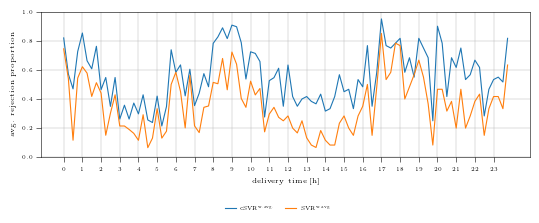

In [83]:
# gather the vanilla SVR results
aggregated_DM_results = []

for trade_horizon in lead_times:
    mae_results = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    f"Forecasting/RESULTS/VANILLA_SVR_MAE/avg_mae_results_{trade_horizon}_{delivery}.pickle",
                    "rb",
                )
            )
            mae_results[delivery] = mae_results_delivery
        except:
            print(f"mae_results_{trade_horizon}_{delivery}.pickle not found")
    results_matrix = pd.DataFrame()
    mae_results_matrix = pd.DataFrame()
    counter_dict = {}
    for d, delivery in enumerate(mae_results.keys()):
        for h, horizon in enumerate(all_forecasting_horizons):
            if horizon not in counter_dict.keys():
                counter_dict[horizon] = 0
            # choose the trade time
            if horizon not in mae_results[delivery].keys():
                continue
            trade_times = []
            for trad in mae_results[delivery][horizon].keys():
                if len(mae_results[delivery][horizon][trad]) > 0:
                    trade_times.append(trad)
            trade_time = trade_times[0]
            if len(mae_results[delivery][horizon][trade_time]) > 0:
                results_matrix.loc[horizon, delivery * 0.25] = mae_results[delivery][
                    horizon
                ][trade_time][col_chosen]
                mae_results_matrix.loc[horizon, delivery * 0.25] = (
                    mae_results[delivery][horizon][trade_time]["prediction_32"]
                    - mae_results[delivery][horizon][trade_time]["naive"]
                ) / mae_results[delivery][horizon][trade_time]["naive"]
                counter_dict[horizon] += 1
    results_matrix = results_matrix.sort_index()
    mae_results_matrix = mae_results_matrix.sort_index()
    aggregated_DM_results.append(
        np.nansum(0.05 >= results_matrix.to_numpy(), axis=0)
        / np.sum(~np.isnan(results_matrix.to_numpy()), axis=0)
    )

vanilla_dm_results_df_total = pd.DataFrame(
    columns=list(results_matrix.columns),
    index=lead_times,
    data=np.vstack(aggregated_DM_results),
)

fig, ax = plt.subplots(figsize=(Image_width, 0.3 * Image_width))
ax.plot(
    dm_results_df_total.columns,
    dm_results_df_total.mean().values,
    lw=0.8,
    label="$\mathrm{cSVR}^{\mathrm{w. avg.}}$",
)
ax.plot(
    vanilla_dm_results_df_total.columns,
    vanilla_dm_results_df_total.mean().values,
    lw=0.8,
    label="$\mathrm{SVR}^{\mathrm{w. avg.}}$",
)
ax.set_xticks(range(24))
ax.grid(visible=True, linewidth=0.3)
fig.legend(
    loc="outside lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.2)
)
# ax.axhline(0.5, ls='--', lw=0.4, color='black')
ax.set_xlabel("delivery time [h]")
ax.set_ylabel("avg. rejection proportion")
ax.set_ylim(0, 1)
plt.savefig(
    "Paper_Figures/vanilla_SVR_and_cSVR_avg_rejections_proportion.pdf",
    bbox_inches="tight",
)

## Fig A.9

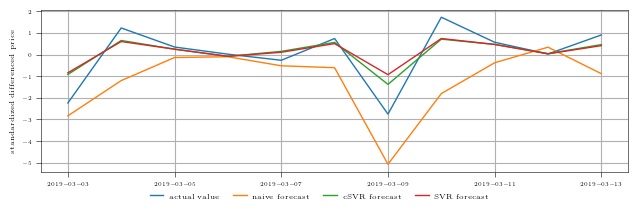

In [ ]:
if raw_data_available:
    # Load CSV
    df_analysis = pd.read_csv(
        "Forecasting/TEST_INSAMPLE/0.00525500182665678_2019-12-09 00;00;00_insample_fit_test.csv",
        index_col=0,
    )

    # Define last date and number of rows
    last_date = pd.to_datetime("2019-12-08")
    num_rows = df_analysis.shape[0]

    # Create datetime index (daily frequency backwards from last_date)
    date_index = pd.date_range(end=last_date, periods=num_rows, freq="D")
    df_analysis.index = date_index

    # Select only the columns you want
    cols_to_plot = ["act", "naive", "7", "plain_laplace_L2_3"]
    names_of_cols = [
        "actual value",
        "naive forecast",
        "cSVR forecast",
        "SVR forecast",
    ]
    df_plot = df_analysis[cols_to_plot]

    # Select only the range of interest (rows 115–125)
    df_plot = df_plot.iloc[115:126]  # 115 to 125 inclusive

    # Plot with Matplotlib
    fig, ax = plt.subplots(figsize=(Paper_width, 0.3 * Paper_width))

    # Plot using ax.plot
    for col_idx, col in enumerate(df_plot.columns):
        ax.plot(df_plot.index, df_plot[col], label=names_of_cols[col_idx], linewidth=1)

    # Set titles and labels
    ax.set_ylabel("standardized differenced price")

    # Legend outside lower center
    fig.legend(
        loc="outside lower center",
        ncol=4,
        frameon=False,
        bbox_to_anchor=(0.5, -0.07),
        fontsize=5,
    )

    # Grid
    ax.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.savefig("Paper_Figures/fit_example.pdf", bbox_inches="tight")

# Fig A.10

In [ ]:
# DA quarterly prices
DA_qtrly = pd.read_csv(
    "Data/Day-Ahead-Quarterly-Data/DA_prices_qtrly_2018_2020_preprocessed.csv",
    index_col=0,
)
DA_qtrly.index = pd.to_datetime(DA_qtrly.index)
DA_qtrly = DA_qtrly[DA_qtrly.index >= datetime(year=2018, month=11, day=1)]

# load Load
Load = pd.read_csv("Data/Load/Load_2018-2020.csv", index_col=0)
Load.index = pd.to_datetime(Load.index)
Load = Load[Load.index >= datetime(year=2018, month=11, day=1)]

# res generation
gen = pd.read_csv("Data/Generation/Generation_2018-2020.csv", index_col=0)
gen.index = pd.to_datetime(gen.index)
gen = gen[gen.index >= datetime(year=2018, month=11, day=1)]

# cross border trade with FR
ge_fr = pd.read_csv("Data/Crossborder/crossborder_ge_fr_2018-2020.csv", index_col=0)
ge_fr.index = pd.to_datetime(ge_fr.index)
ge_fr = ge_fr[ge_fr.index >= datetime(year=2018, month=11, day=1)]

# intraday auction price
ID_qtrly = pd.read_csv(
    "Data/ID_auction_preprocessed/ID_auction_price_2018-2020_preproc.csv", index_col=0
)
ID_qtrly.index = pd.to_datetime(ID_qtrly.index)
ID_qtrly = ID_qtrly[ID_qtrly.index >= datetime(year=2018, month=11, day=1)]

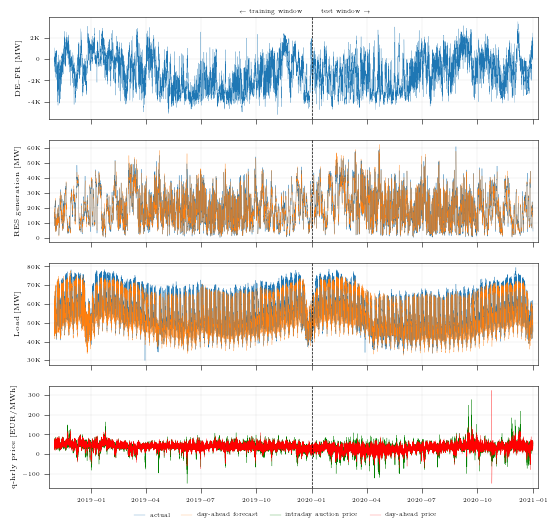

In [ ]:
if raw_data_available:
    f = lambda x, pos: f"{x / 10**3:,.0f}K" if x != 0 else 0
    # Define the date for the vertical line
    split_date = pd.to_datetime("2020-01-01 00:00:00")

    # Create subplots
    fig, axs = plt.subplots(nrows=4, figsize=(Paper_width, 1.1 * Paper_width))

    # Plot the first subplot
    ax = axs[0]
    ax.plot(ge_fr.index, ge_fr["DE > FR"], lw=0.15)
    ax.set_ylabel(r"DE--FR [MW]")
    ax.grid(visible=True, linewidth=0.1)
    ax.axvline(
        split_date, color="black", linestyle="--", linewidth=0.5
    )  # Vertical line at midnight 01-01-2020
    ax.text(
        split_date - timedelta(days=15),
        ax.get_ylim()[1] * 1.05,
        r"$\leftarrow$ training window",
        ha="right",
        va="bottom",
    )
    ax.text(
        split_date + timedelta(days=15),
        ax.get_ylim()[1] * 1.05,
        r"test window $\rightarrow$",
        ha="left",
        va="bottom",
    )
    ax.yaxis.set_major_formatter(FuncFormatter(f))
    ax.margins(x=0.01)

    # Plot the second subplot
    ax = axs[1]
    ax.plot(Load.index, gen["SPV"] + gen["W"], lw=0.2, label="actual")
    ax.plot(Load.index, gen["SPV DA"] + gen["W DA"], lw=0.15, label="day-ahead forecast")
    ax.grid(visible=True, linewidth=0.1)
    ax.set_ylabel("RES generation [MW]")
    ax.axvline(
        split_date, color="black", linestyle="--", linewidth=0.5
    )  # Vertical line at midnight 01-01-2020
    ax.yaxis.set_major_formatter(FuncFormatter(f))
    ax.margins(x=0.01)

    # Plot the third subplot
    ax = axs[2]
    ax.plot(Load.index, Load["Actual"], lw=0.2)
    ax.plot(Load.index, Load["Forecast"], lw=0.15)
    ax.grid(visible=True, linewidth=0.1)
    ax.set_ylabel("Load [MW]")
    ax.axvline(
        split_date, color="black", linestyle="--", linewidth=0.5
    )  # Vertical line at midnight 01-01-2020
    ax.yaxis.set_major_formatter(FuncFormatter(f))
    ax.margins(x=0.01)

    # Plot the fourth subplot
    ax = axs[3]
    ax.plot(
        ID_qtrly.index,
        ID_qtrly.price,
        lw=0.2,
        label="intraday auction price",
        color="green",
    )
    ax.plot(
        DA_qtrly.index,
        DA_qtrly["Price"],
        lw=0.15,
        label="day-ahead price",
        color="red",
    )
    ax.set_ylabel("q-hrly price [EUR/MWh]")
    ax.grid(visible=True, linewidth=0.1)
    ax.axvline(
        split_date, color="black", linestyle="--", linewidth=0.5
    )  # Vertical line at midnight 01-01-2020
    ax.margins(x=0.01)

    # Adjust and save the figure
    fig.legend(
        loc="outside lower center", ncol=4, frameon=False, bbox_to_anchor=(0.5, 0.15)
    )
    fig.autofmt_xdate(rotation=0, ha="center")

    plt.savefig("Paper_Figures/exogenous_variables.pdf", bbox_inches="tight")

## Fig A.11

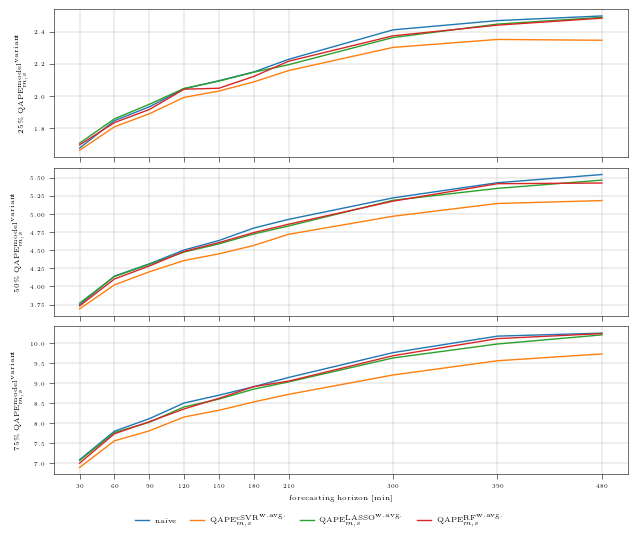

In [87]:
ttd = 0

clean_kernel_names_map = {
    "naive": r"na\"{\i}ve",
    "prediction_32": "$\mathrm{QAPE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32lasso": "$\mathrm{QAPE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32random_forest": "$\mathrm{QAPE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",
}

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, axs = plt.subplots(nrows=3, figsize=(Paper_width, 0.8 * Paper_width))

for measure_idx, measure_type in enumerate(
    ["quantile_0.25", "quantile_0.5", "quantile_0.75"]
):
    ax = axs[measure_idx]
    for idx, forecast_technique in enumerate(list(clean_kernel_names_map.keys())):
        results = {}
        counter_dict = {}
        for delivery in quantile_mae_results[measure_type].keys():
            for horizon in all_forecasting_horizons:
                if horizon not in results.keys():
                    results[horizon] = 0
                    counter_dict[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in quantile_mae_results[measure_type][delivery][
                    horizon
                ].keys():
                    if (
                        len(quantile_mae_results[measure_type][delivery][horizon][trad])
                        > 0
                    ):
                        trade_times.append(trad)
                    elif (2 * (20 + horizon) + 20) < delivery * 15 + 8 * 60 - 60:
                        print(
                            f"Delivery {delivery} results are not available for horizon {horizon}"
                        )
                if len(trade_times) > 0:
                    trade_time = trade_times[ttd]
                    if (
                        len(
                            quantile_mae_results[measure_type][delivery][horizon][
                                trade_time
                            ]
                        )
                        > 0
                        and "naive"
                        in quantile_mae_results[measure_type][delivery][horizon][
                            trade_time
                        ].keys()
                    ):
                        results[horizon] += quantile_mae_results[measure_type][
                            delivery
                        ][horizon][trade_time][forecast_technique]
                        counter_dict[horizon] += 1

        results_plot = []
        for horizon in all_forecasting_horizons:
            if horizon == 30 and counter_dict[horizon] != 96:
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique in list(clean_kernel_names_map.keys()):
            if measure_type == "quantile_0.5":
                ax.plot(
                    all_forecasting_horizons,
                    np.array(results_plot),
                    label=clean_kernel_names_map[forecast_technique],
                    lw=1,
                    color=colors[idx],
                )
            else:
                if measure_type == "quantile_0.25":
                    ax.plot(
                        all_forecasting_horizons,
                        np.array(results_plot),
                        lw=1,
                        color=colors[idx],
                    )
                elif measure_type == "quantile_0.75":
                    ax.plot(
                        all_forecasting_horizons,
                        np.array(results_plot),
                        lw=1,
                        color=colors[idx],
                    )
        ax.grid(visible=True, linewidth=0.3)
        ax.set_ylabel(
            rf"{int(float(measure_type.split('_')[1]) * 100)}\% "
            + "$\mathrm{QAPE}^{\mathrm{model}^\mathrm{variant}}_{m,s}$"
        )
        ax.set_xticks(all_forecasting_horizons)

ax.set_xlabel("forecasting horizon [min]")
# ax.set_ylabel("avg. $(MAE_{model} - MAE_{naive})/MAE_{naive}$")
fig.legend(
    loc="outside lower center",
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
    fontsize=5,
)


fig.autofmt_xdate(rotation=0, ha="center")

plt.tight_layout()
plt.savefig(
    "Paper_Figures/QUANTILE_RANGES_relative_MAE_all_models.pdf", bbox_inches="tight"
)

## Fig A.12

In [ ]:
# load the percentile results
deliveries = np.arange(96)

surprise_mae_results = {}

for measure_type in ["0.25", "0.75"]:
    surprise_mae_results[measure_type] = {}
    for delivery in deliveries:
        try:
            mae_results_delivery = pickle.load(
                open(
                    os.path.join(
                        path_to_mae_aggregations,
                        f"{measure_type}_relative_surprise_avg_mae_results_60_{delivery}.pickle",
                    ),
                    "rb",
                )
            )
            surprise_mae_results[measure_type][delivery] = mae_results_delivery
        except Exception as err:
            print(err)
            print(f"delivery {delivery} not found")

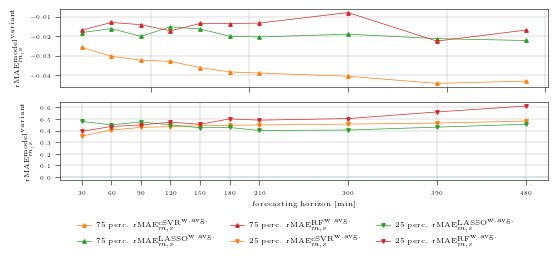

In [89]:
ttd = 0
clean_kernel_names_map = {
    "naive": r"na\"{\i}ve",
    "prediction_32": "$\mathrm{rMAE}^{\mathrm{cSVR}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32lasso": "$\mathrm{rMAE}^{\mathrm{LASSO}^{\mathrm{w. avg.}}}_{m,s}$",
    "prediction_32random_forest": "$\mathrm{rMAE}^{\mathrm{RF}^{\mathrm{w. avg.}}}_{m,s}$",
}

worse_performing_models = {
    "prediction_33": "intel avg. 1,2,7 win 14",
    "prediction_34": "intel avg. 1,2,7 win 21",
    "prediction_35": "intel avg. 1,2,7 win 28",
    "predictionlasso": "$\hat{P}_{LASSO}^{1}$",
    "prediction_closelasso": "$\hat{P}_{LASSO}^{2}$",
    "prediction_exoglasso": "$\hat{P}_{LASSO}^{3}$",
    "predictionrandom_forest": "$\hat{P}_{RF}^{1}$",
    "prediction_closerandom_forest": "$\hat{P}_{RF}^{2}$",
    "prediction_exograndom_forest": "$\hat{P}_{RF}^{3}$",
}

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, axs = plt.subplots(nrows=2, figsize=(Paper_width, 0.4 * Paper_width))

for measure_idx, measure_type in enumerate(["0.75", "0.25"]):
    ax = axs[measure_idx]
    for idx, forecast_technique in enumerate(
        list(clean_kernel_names_map.keys()) + list(worse_performing_models.keys())
    ):
        results = {}
        counter_dict = {}
        for delivery in surprise_mae_results[measure_type].keys():
            for horizon in all_forecasting_horizons:
                if horizon in surprise_mae_results[measure_type][delivery].keys():
                    if horizon not in results.keys():
                        results[horizon] = 0
                        counter_dict[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in surprise_mae_results[measure_type][delivery][
                        horizon
                    ].keys():
                        if (
                            len(
                                surprise_mae_results[measure_type][delivery][horizon][
                                    trad
                                ]
                            )
                            > 0
                        ):
                            trade_times.append(trad)
                        elif (2 * (20 + horizon) + 20) <= delivery * 15 + 8 * 60 - 60:
                            print(
                                f"Delivery {delivery} results are not available for horizon {horizon}"
                            )

                    if len(trade_times) > 0:
                        trade_time = trade_times[ttd]
                        if (
                            len(
                                surprise_mae_results[measure_type][delivery][horizon][
                                    trade_time
                                ]
                            )
                            > 0
                            and "naive"
                            in surprise_mae_results[measure_type][delivery][horizon][
                                trade_time
                            ].keys()
                        ):
                            results[horizon] += surprise_mae_results[measure_type][
                                delivery
                            ][horizon][trade_time][forecast_technique]

                            counter_dict[horizon] += 1
                        else:
                            print(
                                f"WARNING: failed to collect the MAE for delivery {delivery}, horizon {horizon}"
                            )

        results_plot = []
        for horizon in all_forecasting_horizons:
            if (
                horizon == 30 and counter_dict[horizon] != 96
            ):  # sanity check for the deliveries no.
                print(
                    f"Number of deliveries for horizon 30 should always be 96. Is: {counter_dict[horizon]}."
                )

            if counter_dict[horizon] == 0:
                results_plot.append(np.nan)
            else:
                results_plot.append(results[horizon] / counter_dict[horizon])

        if forecast_technique != "naive":
            if forecast_technique in list(clean_kernel_names_map.keys()):
                if measure_type == "0.25":
                    ax.plot(
                        all_forecasting_horizons,
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results),
                        lw=0.5,
                        marker="v",
                        ms=2.5,
                        color=colors[idx],
                        label="25 perc. " + clean_kernel_names_map[forecast_technique],
                    )
                elif measure_type == "0.75":
                    ax.plot(
                        all_forecasting_horizons,
                        (np.array(results_plot) - np.array(naive_results))
                        / np.array(naive_results),
                        lw=0.5,
                        marker="^",
                        ms=2.5,
                        color=colors[idx],
                        label="75 perc. " + clean_kernel_names_map[forecast_technique],
                    )
        else:
            naive_results = results_plot

        ax.set_ylabel("$\mathrm{rMAE}^{\mathrm{model}^\mathrm{variant}}_{m,s}$")
        ax.grid(visible=True, linewidth=0.3)

ax.axhline(0, ls="--", lw=0.2)
ax.set_xlabel("forecasting horizon [min]")
fig.legend(
    loc="outside lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.09),
    fontsize=5,
)

ax.set_xticks(all_forecasting_horizons)

fig.autofmt_xdate(rotation=0, ha="center")
plt.savefig(
    "Paper_Figures/EXTREME_SURPRISE_relative_MAE_all_models.pdf", bbox_inches="tight"
)

# *Supplementary figures generator*

In [90]:
if not run_the_additional_analysis:
    raise SystemExit(
        "No additional analysis required. In case you want to check these results please run with run_the_additional_analysis set to True"
    )

SystemExit: No additional analysis required. In case you want to check these results please run with run_the_additional_analysis set to True

c:\Users\riczi\Studies\PUBLIC_REPOSITORIES\Corrected_Support_Vector_Regression_for_intraday\contmarket311\Lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Analysis of cross-border trades

In [ ]:
plain_data = pd.read_csv("Data/Transactions/concatenated_table.csv")
print(
    "Bought from: \n",
    plain_data.groupby("Area Buy")["Volume (MW)"].sum().sort_values()
    / np.sum(plain_data.groupby("Area Buy")["Volume (MW)"].sum().sort_values()),
)
print(
    "Sold to: \n",
    plain_data.groupby("Market Area Sell")["Volume (MW)"].sum().sort_values()
    / np.sum(plain_data.groupby("Market Area Sell")["Volume (MW)"].sum()),
)

Bought from: 
 Area Buy
NO4     1.743767e-07
NO3     3.904412e-07
NO1     1.988810e-06
NO5     2.536343e-06
NO2     2.690892e-06
SE2     1.231364e-05
SE4     2.249358e-05
SE1     2.448494e-05
FI      4.429169e-05
SE3     9.116396e-05
DK2     5.686451e-04
DK1     1.000222e-03
BE      7.283260e-03
NL      1.719334e-02
AT      1.780483e-02
FR      2.701628e-02
XBID    7.585446e-02
DE      8.530764e-01
Name: Volume (MW), dtype: float64
Sold to: 
 Market Area Sell
NO4     1.418400e-07
NO3     8.764592e-07
SE2     6.401609e-06
NO5     9.155542e-06
NO1     1.243616e-05
SE1     2.055968e-05
SE4     2.186420e-05
NO2     4.262164e-05
FI      8.235310e-05
SE3     2.019410e-04
DK2     5.484855e-04
DK1     1.023960e-03
BE      7.387143e-03
NL      1.468460e-02
AT      2.276870e-02
FR      3.245621e-02
XBID    8.139322e-02
DE      8.393393e-01
Name: Volume (MW), dtype: float64


## Prices and volume exploratory analysis

In [ ]:
df_copy = pd.read_csv("Data/preprocessed_dataset.csv", date_format="%s")
df_copy["Datetime offer time"] = pd.to_datetime(df_copy["Datetime offer time"])
df_copy["Datetime from"] = pd.to_datetime(df_copy["Datetime from"])

Statistics for trades <3h before the delivery

In [ ]:
less_3h = df_copy[
    df_copy["Datetime from"] - df_copy["Datetime offer time"] < timedelta(hours=3)
][["Price (EUR)", "Volume (MW)"]].describe()
less_3h.to_csv("Paper_Tables/less_than_3h_stats.csv")
less_3h

Statistics for trades >3h before the delivery

In [ ]:
more_3h = df_copy[
    df_copy["Datetime from"] - df_copy["Datetime offer time"] > timedelta(hours=3)
][["Price (EUR)", "Volume (MW)"]].describe()
more_3h.to_csv("Paper_Tables/more_than_3h_stats.csv")
more_3h

,Price (EUR),Volume (MW)
count,8.744774e+06,8.744774e+06
mean,3.649961e+01,1.578525e+00
std,2.291518e+01,1.845516e+00
min,-5.694000e+02,1.000000e-01
25%,2.573000e+01,4.000000e-01
50%,3.670000e+01,1.000000e+00
75%,4.795000e+01,2.100000e+00
max,1.244690e+03,3.093000e+02


Ratio of [statistics of price and volume <3h before delivery] and [statistics of price and volume >3h before delivery]

In [ ]:
df_copy[df_copy["Datetime from"] - df_copy["Datetime offer time"] < timedelta(hours=3)][
    ["Price (EUR)", "Volume (MW)"]
].describe() / df_copy[
    df_copy["Datetime from"] - df_copy["Datetime offer time"] > timedelta(hours=3)
][["Price (EUR)", "Volume (MW)"]].describe()

,Price (EUR),Volume (MW)
count,3.841915,3.841915
mean,0.991360,1.180470
std,1.223879,1.279344
min,10.535652,1.000000
25%,0.971628,1.000000
50%,0.980926,1.000000
75%,0.988321,1.238095
max,6.426500,0.973165


# 3D price and volume analysis

C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


-20.5836012942613 95.00917857142856


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


16.97177070266604 68.70666461038962


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


1.8357566137566126 63.072529075091566


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:38: RuntimeWarning: Mean of empty slice
  print(np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2504397464.py:40: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


-21.771473183784533 51.947702020202016


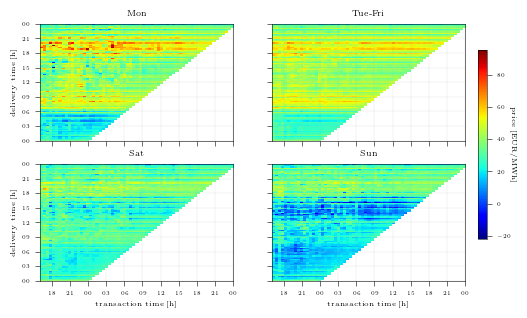

In [ ]:
fig, axs = plt.subplots(
    ncols=2, nrows=2, figsize=(Paper_width, 0.6 * Paper_width), sharex=True, sharey=True
)

titles = ["Mon", "Tue-Fri", "Sat", "Sun"]

collect_matrices = []  # comment if You run 2nd time and set False in line 7

for idx, wday, ax in zip(range(4), [[0], [1, 2, 3, 4], [5], [6]], axs.flat):
    if True:  # change to false if You run cell 2nd time
        df_copy_0 = df_copy[
            ["Datetime from", "Datetime offer time", "Price (EUR)"]
        ].copy(deep=True)
        df_copy_0 = df_copy_0[
            (
                df_copy_0["Datetime from"].dt.date
                != df_copy_0["Datetime offer time"].dt.date
            )
            & (df_copy_0["Datetime from"].dt.weekday.isin(wday))
        ]
        df_copy_0["Datetime offer time"] = pd.to_datetime(
            df_copy_0["Datetime offer time"]
        ).dt.time
        df_copy_0["Datetime from"] = pd.to_datetime(df_copy_0["Datetime from"]).dt.time

        price_avged = df_copy_0.groupby(
            ["Datetime from", "Datetime offer time"]
        ).mean()["Price (EUR)"]

        total_matrix_0 = np.zeros((96, 24 * 60)) * np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_0[
                    i,
                    (
                        datetime.combine(date.today(), g[0])
                        - datetime.today().replace(
                            hour=0, minute=0, second=0, microsecond=0
                        )
                    ).seconds
                    // 60,
                ] = g[1].to_numpy()[0]
        df_copy_1 = df_copy[
            ["Datetime from", "Datetime offer time", "Price (EUR)"]
        ].copy(deep=True)
        df_copy_1 = df_copy_1[
            (
                df_copy_1["Datetime from"].dt.date
                == df_copy_1["Datetime offer time"].dt.date
            )
            & (df_copy_1["Datetime from"].dt.weekday.isin(wday))
        ]
        df_copy_1["Datetime offer time"] = pd.to_datetime(
            df_copy_1["Datetime offer time"]
        ).dt.time
        df_copy_1["Datetime from"] = pd.to_datetime(df_copy_1["Datetime from"]).dt.time

        price_avged = df_copy_1.groupby(
            ["Datetime from", "Datetime offer time"]
        ).mean()["Price (EUR)"]

        total_matrix_1 = np.zeros((96, 24 * 60)) * np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_1[
                    i + 1,
                    (
                        datetime.combine(date.today(), g[0])
                        - datetime.today().replace(
                            hour=0, minute=0, second=0, microsecond=0
                        )
                    ).seconds
                    // 60,
                ] = g[1].to_numpy()[0]

        total_matrix = np.hstack((total_matrix_0, total_matrix_1))

        collect_matrices.append(total_matrix)
    else:
        total_matrix = collect_matrices[idx]

    print(
        np.nanmin(
            np.nanmean(total_matrix.reshape((96, 1440 // 30 * 2, 30)), axis=2)[:, 32:-1]
        ),
        np.nanmax(
            np.nanmean(total_matrix.reshape((96, 1440 // 30 * 2, 30)), axis=2)[:, 32:-1]
        ),
    )

    im = ax.imshow(
        np.nanmean(total_matrix.reshape((96, 1440 // 30 * 2, 30)), axis=2)[:, 32:-1],
        origin="lower",
        aspect="auto",
        cmap="jet",
        extent=[
            datetime.today().replace(hour=16, minute=0, second=0, microsecond=0),
            date.today() + timedelta(days=2),
            date.today() + timedelta(days=1),
            date.today() + timedelta(days=2) - timedelta(minutes=15),
        ],
        interpolation="none",
        vmin=-22,
        vmax=95,
    )

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    # cbar = fig.colorbar(im)
    # cbar.set_label('price [EUR/MWh]', rotation=270, labelpad=12)
    if idx > 1:
        ax.set_xlabel("transaction time [h]")
    if idx in [0, 2]:
        ax.set_ylabel("delivery time [h]")
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])
fig.autofmt_xdate(rotation=0, ha="center")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("price [EUR/MWh]", rotation=270, labelpad=5)

plt.savefig("Paper_Figures/mon_aggtuefri_sat_sun_3D_prices.pdf", bbox_inches="tight")

21146.0 8.0
21328.75 14.5
19748.0 8.0
19175.0 9.0


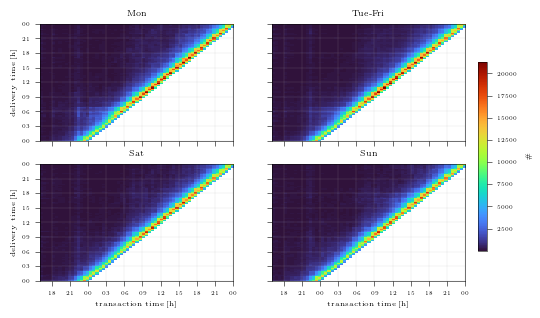

In [ ]:
fig, axs = plt.subplots(
    ncols=2, nrows=2, figsize=(Paper_width, 0.6 * Paper_width), sharex=True, sharey=True
)

titles = ["Mon", "Tue-Fri", "Sat", "Sun"]

for idx, wday, ax in zip(range(4), [[0], [1, 2, 3, 4], [5], [6]], axs.flat):
    df_copy_0 = df_copy[["Datetime from", "Datetime offer time", "Price (EUR)"]].copy(
        deep=True
    )
    df_copy_0 = df_copy_0[
        (df_copy_0["Datetime from"].dt.date != df_copy_0["Datetime offer time"].dt.date)
        & (df_copy_0["Datetime from"].dt.weekday.isin(wday))
    ]
    df_copy_0["Datetime offer time"] = pd.to_datetime(
        df_copy_0["Datetime offer time"]
    ).dt.time
    df_copy_0["Datetime from"] = pd.to_datetime(df_copy_0["Datetime from"]).dt.time

    price_avged = df_copy_0.groupby(["Datetime from", "Datetime offer time"]).count()[
        "Price (EUR)"
    ]

    total_matrix_0 = np.zeros((96, 24 * 60)) * np.nan
    for i, group in enumerate(price_avged.groupby(level=0)):
        for j, g in enumerate(group[1].groupby(level=1)):
            total_matrix_0[
                i,
                (
                    datetime.combine(date.today(), g[0])
                    - datetime.today().replace(
                        hour=0, minute=0, second=0, microsecond=0
                    )
                ).seconds
                // 60,
            ] = g[1].to_numpy()[0]
    df_copy_1 = df_copy[["Datetime from", "Datetime offer time", "Price (EUR)"]].copy(
        deep=True
    )
    df_copy_1 = df_copy_1[
        (df_copy_1["Datetime from"].dt.date == df_copy_1["Datetime offer time"].dt.date)
        & (df_copy_1["Datetime from"].dt.weekday.isin(wday))
    ]
    df_copy_1["Datetime offer time"] = pd.to_datetime(
        df_copy_1["Datetime offer time"]
    ).dt.time
    df_copy_1["Datetime from"] = pd.to_datetime(df_copy_1["Datetime from"]).dt.time

    price_avged = df_copy_1.groupby(["Datetime from", "Datetime offer time"]).count()[
        "Price (EUR)"
    ]

    total_matrix_1 = np.zeros((96, 24 * 60)) * np.nan
    for i, group in enumerate(price_avged.groupby(level=0)):
        for j, g in enumerate(group[1].groupby(level=1)):
            total_matrix_1[
                i + 1,
                (
                    datetime.combine(date.today(), g[0])
                    - datetime.today().replace(
                        hour=0, minute=0, second=0, microsecond=0
                    )
                ).seconds
                // 60,
            ] = g[1].to_numpy()[0]

    total_matrix = np.hstack((total_matrix_0, total_matrix_1))

    if idx == 1:
        total_matrix = total_matrix / 4

    sum_matrix = np.nansum(total_matrix.reshape((96, 1440 // 30 * 2, 30)), axis=2)[
        :, 32:-1
    ]
    sum_matrix[sum_matrix == 0] = np.nan

    im = ax.imshow(
        sum_matrix,
        origin="lower",
        aspect="auto",
        cmap="turbo",
        extent=[
            datetime.today().replace(hour=16, minute=0, second=0, microsecond=0),
            date.today() + timedelta(days=2),
            date.today() + timedelta(days=1),
            date.today() + timedelta(days=2) - timedelta(minutes=15),
        ],
        interpolation="none",
        vmin=8.0,
        vmax=21328.75,
    )

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    if idx > 1:
        ax.set_xlabel("transaction time [h]")
    if idx in [0, 2]:
        ax.set_ylabel("delivery time [h]")
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])

fig.autofmt_xdate(rotation=0, ha="center")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.28, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("\#", rotation=270, labelpad=11)

plt.savefig(
    "Paper_Figures/mon_aggtuefri_sat_sun_3D_avg_daily_trades_no.pdf",
    bbox_inches="tight",
)

C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


57.68355067309902 0.019445436482630897


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


77.45597441758358 0.49417173505020545


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


35.80679919129356 0.0


C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:60: RuntimeWarning: Mean of empty slice
  print(np.nanmax(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]), np.nanmin(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1]))
C:\Users\riczi\AppData\Local\Temp\ipykernel_38716\2329724152.py:61: RuntimeWarning: Mean of empty slice
  im = ax.imshow(np.nanmean(total_matrix.reshape((96,1440//30*2, 30)), axis=2)[:,32:-1], origin='lower', aspect='auto',


46.32558200932583 0.2441998088025988


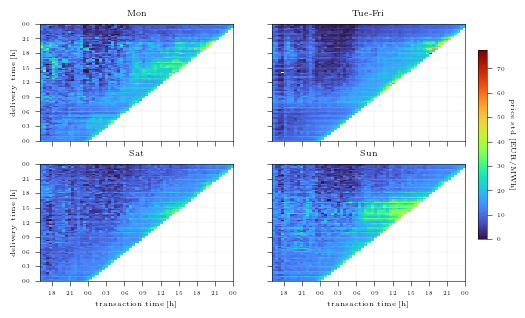

In [ ]:
fig, axs = plt.subplots(
    ncols=2, nrows=2, figsize=(Paper_width, 0.6 * Paper_width), sharex=True, sharey=True
)

titles = ["Mon", "Tue-Fri", "Sat", "Sun"]

for idx, wday, ax in zip(range(4), [[0], [1, 2, 3, 4], [5], [6]], axs.flat):
    if idx != 1:
        df_copy_0 = df_copy[
            ["Datetime from", "Datetime offer time", "Price (EUR)"]
        ].copy(deep=True)
        df_copy_0 = df_copy_0[
            (
                df_copy_0["Datetime from"].dt.date
                != df_copy_0["Datetime offer time"].dt.date
            )
            & (df_copy_0["Datetime from"].dt.weekday.isin(wday))
        ]
        df_copy_0["Datetime offer time"] = pd.to_datetime(
            df_copy_0["Datetime offer time"]
        ).dt.time
        df_copy_0["Datetime from"] = pd.to_datetime(df_copy_0["Datetime from"]).dt.time

        price_avged = df_copy_0.groupby(["Datetime from", "Datetime offer time"]).std()[
            "Price (EUR)"
        ]

        total_matrix_0 = np.zeros((96, 24 * 60)) * np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_0[
                    i,
                    (
                        datetime.combine(date.today(), g[0])
                        - datetime.today().replace(
                            hour=0, minute=0, second=0, microsecond=0
                        )
                    ).seconds
                    // 60,
                ] = g[1].to_numpy()[0]
        df_copy_1 = df_copy[
            ["Datetime from", "Datetime offer time", "Price (EUR)"]
        ].copy(deep=True)
        df_copy_1 = df_copy_1[
            (
                df_copy_1["Datetime from"].dt.date
                == df_copy_1["Datetime offer time"].dt.date
            )
            & (df_copy_1["Datetime from"].dt.weekday.isin(wday))
        ]
        df_copy_1["Datetime offer time"] = pd.to_datetime(
            df_copy_1["Datetime offer time"]
        ).dt.time
        df_copy_1["Datetime from"] = pd.to_datetime(df_copy_1["Datetime from"]).dt.time

        price_avged = df_copy_1.groupby(["Datetime from", "Datetime offer time"]).std()[
            "Price (EUR)"
        ]

        total_matrix_1 = np.zeros((96, 24 * 60)) * np.nan
        for i, group in enumerate(price_avged.groupby(level=0)):
            for j, g in enumerate(group[1].groupby(level=1)):
                total_matrix_1[
                    i + 1,
                    (
                        datetime.combine(date.today(), g[0])
                        - datetime.today().replace(
                            hour=0, minute=0, second=0, microsecond=0
                        )
                    ).seconds
                    // 60,
                ] = g[1].to_numpy()[0]
        total_matrix = np.hstack((total_matrix_0, total_matrix_1))

    else:
        total_matrix_4_days = np.zeros((96, 48 * 60))
        for day in wday:
            df_copy_0 = df_copy[
                ["Datetime from", "Datetime offer time", "Price (EUR)"]
            ].copy(deep=True)
            df_copy_0 = df_copy_0[
                (
                    df_copy_0["Datetime from"].dt.date
                    != df_copy_0["Datetime offer time"].dt.date
                )
                & (df_copy_0["Datetime from"].dt.weekday.isin([day]))
            ]
            df_copy_0["Datetime offer time"] = pd.to_datetime(
                df_copy_0["Datetime offer time"]
            ).dt.time
            df_copy_0["Datetime from"] = pd.to_datetime(
                df_copy_0["Datetime from"]
            ).dt.time

            price_avged = df_copy_0.groupby(
                ["Datetime from", "Datetime offer time"]
            ).std()["Price (EUR)"]

            total_matrix_0 = np.zeros((96, 24 * 60))
            for i, group in enumerate(price_avged.groupby(level=0)):
                for j, g in enumerate(group[1].groupby(level=1)):
                    total_matrix_0[
                        i,
                        (
                            datetime.combine(date.today(), g[0])
                            - datetime.today().replace(
                                hour=0, minute=0, second=0, microsecond=0
                            )
                        ).seconds
                        // 60,
                    ] = g[1].to_numpy()[0]
            df_copy_1 = df_copy[
                ["Datetime from", "Datetime offer time", "Price (EUR)"]
            ].copy(deep=True)
            df_copy_1 = df_copy_1[
                (
                    df_copy_1["Datetime from"].dt.date
                    == df_copy_1["Datetime offer time"].dt.date
                )
                & (df_copy_1["Datetime from"].dt.weekday.isin([day]))
            ]
            df_copy_1["Datetime offer time"] = pd.to_datetime(
                df_copy_1["Datetime offer time"]
            ).dt.time
            df_copy_1["Datetime from"] = pd.to_datetime(
                df_copy_1["Datetime from"]
            ).dt.time

            price_avged = df_copy_1.groupby(
                ["Datetime from", "Datetime offer time"]
            ).std()["Price (EUR)"]

            total_matrix_1 = np.zeros((96, 24 * 60))
            for i, group in enumerate(price_avged.groupby(level=0)):
                for j, g in enumerate(group[1].groupby(level=1)):
                    total_matrix_1[
                        i + 1,
                        (
                            datetime.combine(date.today(), g[0])
                            - datetime.today().replace(
                                hour=0, minute=0, second=0, microsecond=0
                            )
                        ).seconds
                        // 60,
                    ] = g[1].to_numpy()[0]
            total_matrix = np.hstack((total_matrix_0, total_matrix_1))
            total_matrix_4_days = np.sum(
                np.dstack((total_matrix_4_days, total_matrix)), 2
            )
        total_matrix = total_matrix_4_days / 4
        total_matrix[total_matrix == 0] = np.nan
    im = ax.imshow(
        np.nanmean(total_matrix.reshape((96, 1440 // 30 * 2, 30)), axis=2)[:, 32:-1],
        origin="lower",
        aspect="auto",
        cmap="turbo",
        extent=[
            datetime.today().replace(hour=16, minute=0, second=0, microsecond=0),
            date.today() + timedelta(days=2),
            date.today() + timedelta(days=1),
            date.today() + timedelta(days=2) - timedelta(minutes=15),
        ],
        interpolation="none",
        vmin=0,
        vmax=77.45597441758358,
    )

    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
    ax.yaxis_date()
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H"))

    if idx > 1:
        ax.set_xlabel("transaction time [h]")
    if idx in [0, 2]:
        ax.set_ylabel("delivery time [h]")
    ax.grid(visible=True, linewidth=0.1)
    ax.set_title(titles[idx])

fig.autofmt_xdate(rotation=0, ha="center")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.31, 0.015, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("price std [EUR/MWh]", rotation=270, labelpad=8)
plt.savefig(
    "Paper_Figures/mon_aggtuefri_sat_sun_3D_avg_daily_std.pdf", bbox_inches="tight"
)